In [1]:
import numpy as np
import random

from keras.layers import Input,merge
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Cropping2D, Convolution2D, Deconvolution2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
import keras
from keras.models import Model

from tqdm import tqdm


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


In [2]:
from sklearn.externals import joblib
import numpy as np

def load_train(filename, dim_ordering = 'th', debug = True, bgr_to_rgb = False) :
    # Expects files to be loaded and pickled as RGB image 
    X = joblib.load(filename)['X']

    # Scale color range from (0, 1) to (-1, 1)
    X = X * 2 - 1
    assert np.min(X) >= -1.0 and np.max(X) <= 1.0
    if debug :
        print "Color range: ", np.min(X), np.max(X)
    
    if bgr_to_rgb :
        X = X[:, :, :, [2, 1, 0]]
    
    assert X.shape[-1] == 3
    if dim_ordering == 'th' :
        # Change dim_ordering from TF (count_images, height, width, 3) to theano (count_images, 3, height, width)
        X = np.swapaxes(X, 2, 3)
        X = np.swapaxes(X, 1, 2)
    elif dim_ordering == 'tf' :
        pass
    else :
        raise ValueError('Dim ordering %s is not supported' % dim_ordering)
    
    if debug :
        print('Shape:', X.shape)
    
    return X


In [5]:
%%time

X = load_train('dataset/pixelart-48x48.dump')

Color range:  -1.0 1.0
('Shape:', (87514, 3, 48, 48))
CPU times: user 4.34 s, sys: 5.95 s, total: 10.3 s
Wall time: 22.5 s


In [4]:
def generator_block(input_node, input_shape, leaku_relu_alpha) :    
    channels, height, width = input_shape
    output_shape = (None, channels / 2, height * 2 + 2, width * 2 + 2)  
    
    block = Deconvolution2D(
        output_shape[1], 
        4, 4, 
        output_shape = output_shape, 
        border_mode='valid', 
        init='glorot_uniform', 
        subsample = (2, 2),
    )(input_node)
    block = Cropping2D(((1, 1), (1, 1)))(block)
    block = BatchNormalization(mode = 2)(block)
    block = LeakyReLU(leaku_relu_alpha)(block)

    return block


def build_generator(initial_size = (3, 3), channels_count = 32 * 32, leaky_relu_alpha = 0.2) :
    generator_input = Input(shape=[100])
    
    initial_height, initial_width = initial_size
    
    H = Dense(channels_count * initial_height * initial_width, init='glorot_normal')(generator_input)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(0.2)(H)
    H = Reshape([channels_count, initial_height, initial_width] )(H) # nch

    # 4 layers result in x16 increased picture size, (3, 3) -> (48, 48)

    H = generator_block(H, (channels_count, initial_height, initial_width), leaky_relu_alpha)
    H = generator_block(H, (channels_count / 2 , initial_height * 2, initial_width * 2), leaky_relu_alpha)
    H = generator_block(H, (channels_count / 4 , initial_height * 4, initial_width * 4), leaky_relu_alpha)
    H = generator_block(H, (channels_count / 8 , initial_height * 8, initial_width * 8), leaky_relu_alpha)

    H = Convolution2D(channels_count / 32, 3, 3, border_mode='same', init='glorot_uniform')(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)

    H = Convolution2D(3, 1, 1, border_mode='same', init='glorot_uniform')(H)
    generator_output = Activation('tanh')(H)

    generator = Model(generator_input, generator_output)
    generator_output_shape = (3, initial_height * 16, initial_width * 16)

    return generator, generator_input, generator_output_shape


def build_discriminator(input_shape, discriminator_base_channels = 64, leaky_relu_alpha = 0.2, dropout_rate = 0.25) :
    discriminator_input = Input(shape = input_shape)
    H = Convolution2D(discriminator_base_channels * 3, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(discriminator_input)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    
    H = Convolution2D(discriminator_base_channels * 4, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    
    H = Convolution2D(discriminator_base_channels * 6, 3, 3, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    
    H = Convolution2D(discriminator_base_channels * 3, 1, 1, border_mode = 'same', activation='relu')(H)
    H = LeakyReLU(leaky_relu_alpha)(H)
    H = Dropout(dropout_rate)(H)
    H = Flatten()(H)
    
    H = Dense(discriminator_base_channels * 2)(H)
    H = LeakyReLU(0.2)(H)
    discriminator_output = Dense(2, activation='softmax')(H)
    
    discriminator = Model(discriminator_input, discriminator_output)
    return discriminator, discriminator_output
    
    
def make_trainable(model, mode):
    model.trainable = mode
    for layer in model.layers:
        layer.trainable = mode
    
    
def build_models(
    debug = True, 
    generator_optimizer = Adam(lr = 5e-4), 
    discriminator_optimizer = SGD(lr=5e-3, momentum = 0.9),
    discriminator_dropout_rate = 0.25,
    generator_initial_size = (3, 3),
) :
    generator, generator_input, generator_output_shape = build_generator(generator_initial_size) 
    generator.compile(loss='binary_crossentropy', optimizer = generator_optimizer, metrics = ['accuracy'])

    if debug :
        generator.summary()
    
    input_shape = generator_output_shape
    discriminator, discriminator_output = build_discriminator(input_shape, dropout_rate = discriminator_dropout_rate)
    discriminator.compile(loss='categorical_crossentropy', optimizer = discriminator_optimizer, metrics = ['accuracy'])
    if debug :
        discriminator.summary()
        
    # Freeze weights in the discriminator for stacked training
    make_trainable(discriminator, False)
    
    gan_input = Input(shape=[100])
    H = generator(gan_input)
    gan_output = discriminator(H)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='categorical_crossentropy', optimizer=generator_optimizer, metrics = ['accuracy'])
    if debug :
        gan.summary()
        
    return generator, discriminator, gan, generator_optimizer, discriminator_optimizer

In [5]:
generator, discriminator, gan, generator_optimizer, discriminator_optimizer = build_models()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 9216)          930816      input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 9216)          36864       dense_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 9216)          0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [6]:
def noise_generator(batch, size = 100) :
    # Normal (0, 1) noise instead of uniform as in original DCGAN 
    return np.random.normal(0, 1, size=[batch,100])

In [7]:
# Pre-train the discriminator network ...
def pretrain_discriminator(discriminator, X, pretrain_size = 10000) :
    train_ids = random.sample(range(0, X.shape[0]), pretrain_size)
    X_pretrain = X[train_ids, :, :, :]

    noise = noise_generator(pretrain_size)
    generated_images = generator.predict(noise)
    X_pretrain = np.concatenate([X_pretrain, generated_images])

    y = np.zeros([pretrain_size * 2, 2])
    # Real images
    y[:pretrain_size, 1] = 1    
    # Generated
    y[pretrain_size:, 0] = 1

    make_trainable(discriminator, True)
    discriminator.fit(X_pretrain, y, nb_epoch=2, batch_size=256, verbose = 0)
    return discriminator.evaluate(X_pretrain, y, verbose = 0)

In [8]:
%%time

pretrain_discriminator(discriminator, X)

CPU times: user 46.3 s, sys: 13.5 s, total: 59.8 s
Wall time: 1min


[0.00070336072817171952, 0.99985000000000002]

In [16]:
def history_replay(history, batch_size) :
    assert batch_size % len(history) == 0
    
    history_batch = []
    for history_images in history :
        images_count = batch_size / len(history)
        history_batch.append(
            history_images[
                np.random.randint(0, history_images.shape[0], size = images_count)
            ]
        )
    history_batch = np.concatenate(history_batch)
    return history_batch


def train_discriminator(discriminator, history, X, batch_size, losses) :
    make_trainable(discriminator, True)

    X_fake = history_replay(history, batch_size)
    y = np.zeros([batch_size, 2])
    
    # Soft-noisy labels
    y[:, 0] = np.random.uniform(0.7, 1.0, size=[batch_size])
    y[:, 1] = -y[:, 0] + 1.0
    
    loss_fake, accuracy_fake = discriminator.train_on_batch(X_fake, y)
    
    X_real = X[np.random.randint(0, X.shape[0],size = batch_size),:,:,:]    
    y = np.zeros([batch_size, 2])
    y[:, 1] = np.random.uniform(0.7, 1.2, size=[batch_size])
    y[:, 0] = -y[:, 1] + 1.0
    
    loss_real, accuracy_real  = discriminator.train_on_batch(X_real, y)
    for name, loss in [
        ('discriminator accuracy real', accuracy_real),
        ('discriminator accuracy fake', accuracy_fake),
        ('discriminator logloss real', loss_real),
        ('discriminator logloss fake', loss_fake),
    ] :
        losses[name].append(loss)

        
def train_generator(gan, generator, batch_size, losses) :
    g_loss = 0
    make_trainable(discriminator, False)
    noise = noise_generator(batch_size)
    y = np.zeros([batch_size,  2])
    y[:, 1] = 1

    loss, accuracy = gan.train_on_batch(noise, y)
    for name, loss in [
        ('generator accuracy', accuracy),
        ('generator logloss', loss),
    ] :
        losses[name].append(loss)

!mkdir samples
!mkdir samples/tiled-48
!mkdir samples/tiled-48/shaking
        
rows, columns = 9, 9

def save_models(generator, discriminator, gan) :
    generator.save('generator.model')
    discriminator.save('discriminator.model')
    gan.save('gan.model')
    
def train_gan(discriminator, gan, generator, losses, epoch_count = 500000, plot_frequency = 50, render_frequency = 1000, batch_size = 32, history_length = 8) :
    # History replay-like heuristic used to train discriminator 
    history = []
    for i in range(history_length - 1) : 
        noise = noise_generator(batch_size)
        generated_images = generator.predict(noise)    
        history.append(generated_images)
        
    for epoch in tqdm(range(epoch_count)) :
        noise_gen = np.random.uniform(0, 1, size=[batch_size,100])
        generated_images = generator.predict(noise_gen)
        history.append(generated_images)
        
        train_discriminator(discriminator, history, X, batch_size, losses)
        train_generator(gan, generator, batch_size, losses)

        history.pop(random.choice(range(history_length)))
        
        if epoch % plot_frequency == 0 :
            plot_loss(losses)
            plot_generator()
            
        if epoch % render_frequency == 0 :
            images = image_shaking(generator, images_count = rows, shakes_count = columns, noise = fixed_noise[:rows])
            save_tiled(
                images, 
                'samples/tiled-48/shaking/epoch-%d.png' % epoch, 
                rows, 
                columns,
                image_size = (48, 48)
            )
            save_models(generator, discriminator, gan)

mkdir: cannot create directory ‘samples’: File exists
mkdir: cannot create directory ‘samples/tiled-48’: File exists
mkdir: cannot create directory ‘samples/tiled-48/shaking’: File exists


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import pandas as pd
#pandas used to efficiently calculate rolling_mean

def plot_loss(
    losses, 
    names = (
        'discriminator accuracy real',
        'discriminator accuracy fake',
        'discriminator logloss real',
        'discriminator logloss fake',
        'generator accuracy',
        'generator logloss',
    ),
    average_window = 100,
):
    display.clear_output(wait = True)
    display.display(plt.gcf())
    plt.figure(figsize=(12, 8))
    for name in names :
        plt.plot(
            pd.rolling_mean(pd.Series(losses[name]), window = average_window).values, 
            label = name
        )
    
    plt.legend()
    plt.show()
    
def plot_grid(images, dimensions = (5, 5), figsize=(10, 10)) :
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dimensions[0], dimensions[1], i + 1)
        
        # (-1, 1) color range to (0, 1)
        image = (images[i, :, :, :] + 1.0) * 0.5
        
        plt.imshow(image)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_dimensions = (5, 5)
plot_image_count = np.prod(plot_dimensions)
fixed_noise = noise_generator(plot_image_count)

def plot_generator(n_images = plot_image_count, dimensions = plot_dimensions, figsize = (10, 10), fixed_set = True):
    if fixed_set :
        noise = fixed_noise
    else :
        noise = noise_generator(n_ex)
        
    generated_images = generator.predict(noise)
    
    # Convert to (height, width, RGB)
    generated_images = np.swapaxes(generated_images, 1, 2)
    generated_images = np.swapaxes(generated_images, 2, 3)
    
    plot_grid(generated_images, plot_dimensions, figsize)

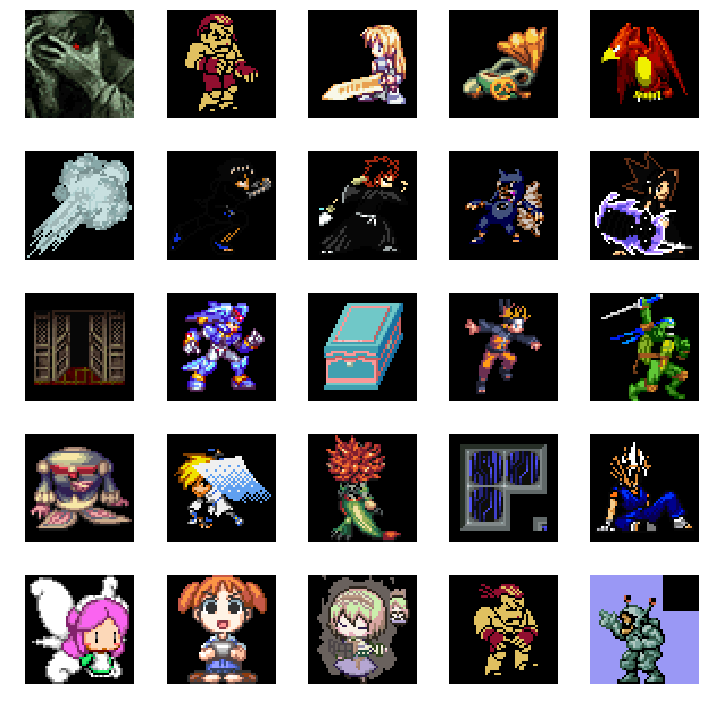

In [11]:
plot_dimensions = (5, 5)
plot_image_count = np.prod(plot_dimensions)

def plot_real(X, images_count = plot_image_count, dimensions = plot_dimensions, figsize=(10,10)):
    images_ids = np.random.randint(0, X.shape[0], images_count)
    images = X[images_ids, :, :, :][:, :, :, :]
    
    
    images = np.swapaxes(images, 1, 2)
    images = np.swapaxes(images, 2, 3)
    
    plot_grid(images, dimensions = dimensions)
    
plot_real(X)

In [21]:
def swap_dimensions(images) :
    images = np.swapaxes(images, 1, 2)
    images = np.swapaxes(images, 2, 3)
    return images

def shake(v, rate = 0.1) :
    return v * np.random.uniform(1.0 - rate, 1.0 + rate, size=100)


def image_shaking(generator, images_count = 9, shakes_count = 9, noise = None) :
    if noise is None :
        noise = noise_generator(images_count)
    
    input_vectors = []
    for i in range(images_count) :        
        for j in range(shakes_count) :
            original = np.array(noise[i])
            if i > 0 :
                shaked = shake(original, 0.3)
            else :
                shaked = original
                
            input_vectors.append(shaked)
    
    input_vectors = np.stack(input_vectors)
    generated_images = generator.predict(input_vectors, batch_size = images_count * shakes_count)
    generated_images = np.swapaxes(generated_images, 1, 2)
    generated_images = np.swapaxes(generated_images, 2, 3)
    generated_images = (generated_images + 1.0) * 0.5
        
    return generated_images

In [22]:
import cv2

def convert_to_tiles(images, target_tiling = (9, 9), image_size = (48, 48)) :
    width = target_tiling[1] * (image_size[1] + 1) - 1
    height = target_tiling[0] * (image_size[0] + 1) - 1
    
    result = np.ones((height, width, 3), dtype = np.uint8) * 255
    for index, image in zip(
        range(target_tiling[0] * target_tiling[1]),
        (images * 255).astype(np.uint8)
    ) :
        x_index = index % target_tiling[1]
        y_index = index / target_tiling[1]
        
        left = x_index * (image_size[0] + 1)
        top = y_index * (image_size[1] + 1)
        
        result[top:top + image_size[1], left:left + image_size[0]] = image 
        
    return result

def save_tiled(images, filename, grid_in_row, grid_in_column, image_size = (48, 48)) :
    tiled = convert_to_tiles(
        images, 
        target_tiling = (grid_in_row, grid_in_column), 
        image_size = image_size
    )
    
    # Convert RGB to BGR before saving in opencv

    return cv2.imwrite(filename, tiled[:, :, [2, 1, 0]])

In [ ]:
losses = dict([
    (name, []) for name in (
        'discriminator accuracy real',
        'discriminator accuracy fake',
        'discriminator logloss real',
        'discriminator logloss fake',
        'generator accuracy',
        'generator logloss',
    )
])
losses

{'discriminator accuracy fake': [],
 'discriminator accuracy real': [],
 'discriminator logloss fake': [],
 'discriminator logloss real': [],
 'generator accuracy': [],
 'generator logloss': []}

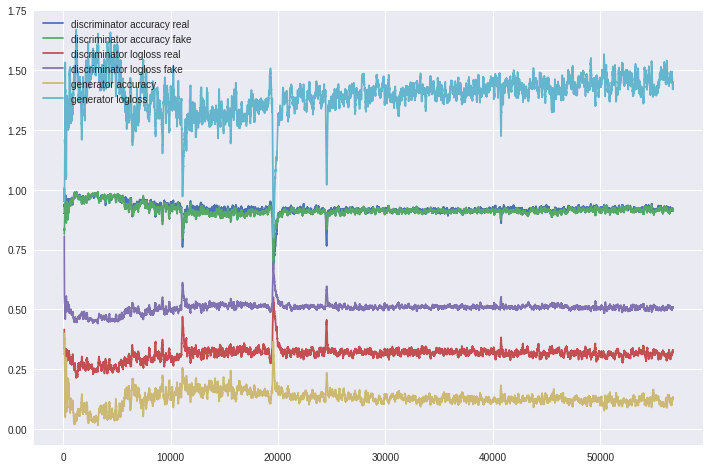

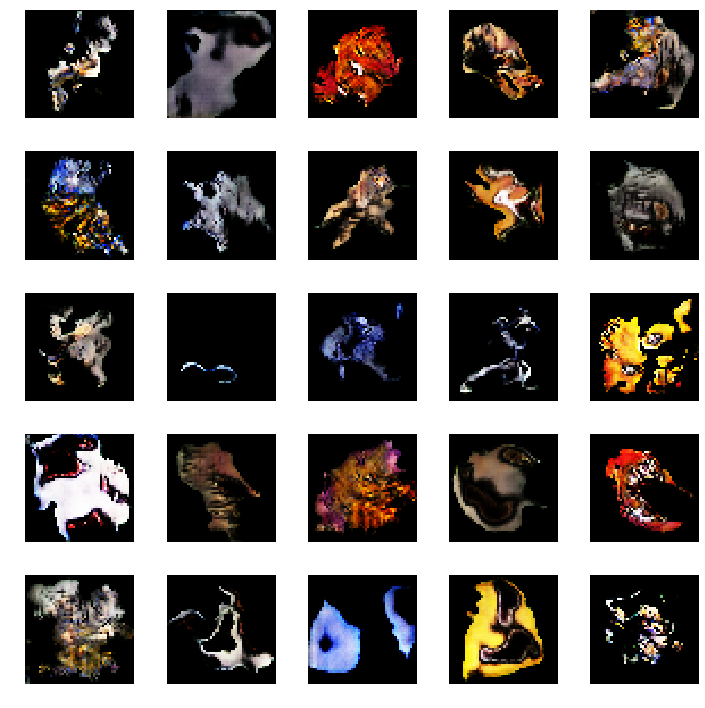

  1%|          | 5865/500000 [33:25<44:34:33,  3.08it/s] 

In [ ]:
train_gan(discriminator, gan, generator, losses, epoch_count = 500000, plot_frequency = 200, batch_size=32)

In [ ]:







































def set_learning_rate(optimizer, lr) :
    optimizer.lr.set_value(lr)

In [ ]:
generator.save('generator.model')
discriminator.save('discriminator.model')
gan.save('GAN.model')